In [1]:
%load_ext autoreload
%autoreload 2
import sys; sys.path.append('../../'); from config import *
configure_pylab()

Available files:
	r2288_180515b_tet2_cell2_GC.mat
	r2289_250515b_tet2_cell2_GC.mat
	r2298_290615c_tet6_cell6_GC.mat
	r2375_070416a_tet1_cell1_GC.mat
	r2375_140416b_tet1_cell1_GC.mat
	r2375_210416a_tet3_cell3_GC.mat
	r2383_160516b_tet4_cell4_GC.mat
	r2405_011216a_cell2955.mat
	r2405_051216b_cell1816.mat
	r2405_121216b_cell1880.mat
	r2405_121216b_cell1912.mat
	r2405_191216c_cell1640.mat
	r2405_191216c_cell1662.mat
	r2405_191216c_cell1962.mat
	r2405_191216c_cell1990.mat
Fitted models in fitdir = /home/mer49/Desktop/lgcpspatial/python/notebooks/hyperparameter_fits/


# Posterior confidence via sampling

### Retrieve model

r2288_180515b_tet2_cell2_GC.mat


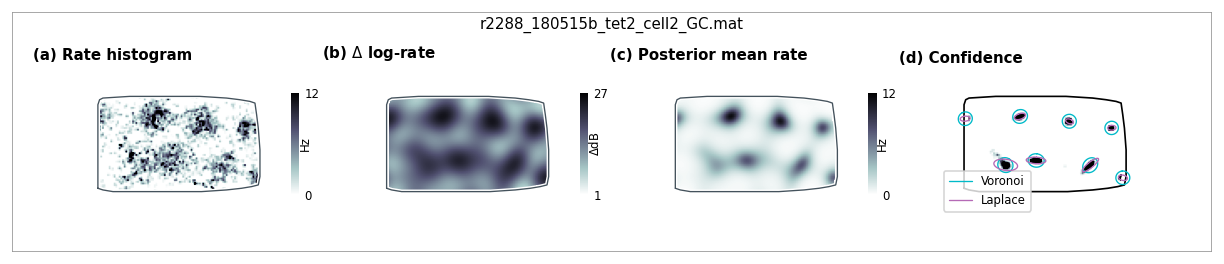

r2289_250515b_tet2_cell2_GC.mat


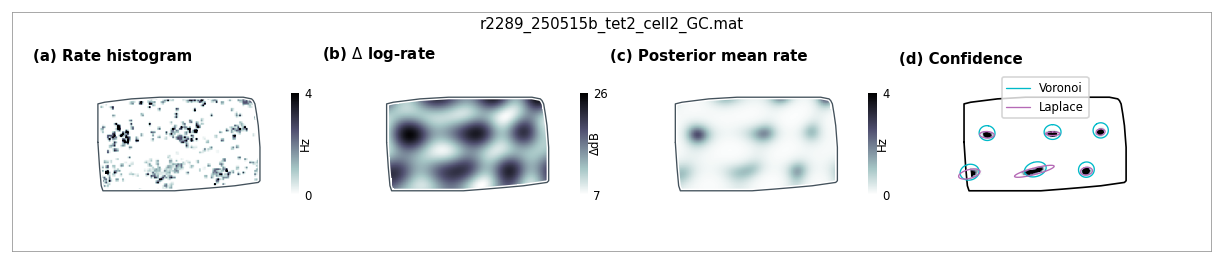

r2298_290615c_tet6_cell6_GC.mat


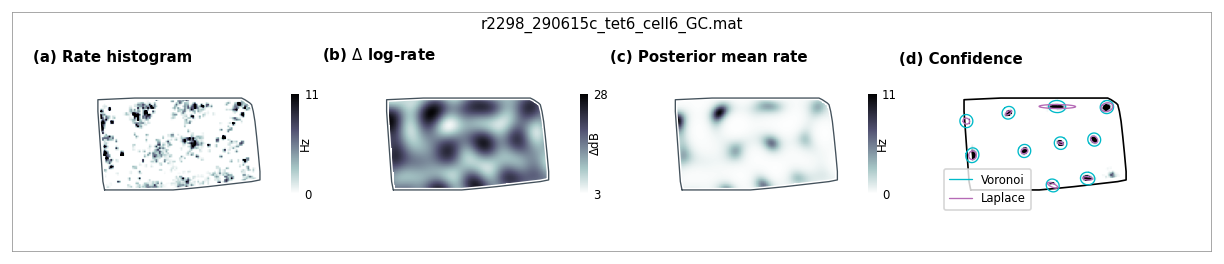

r2375_070416a_tet1_cell1_GC.mat


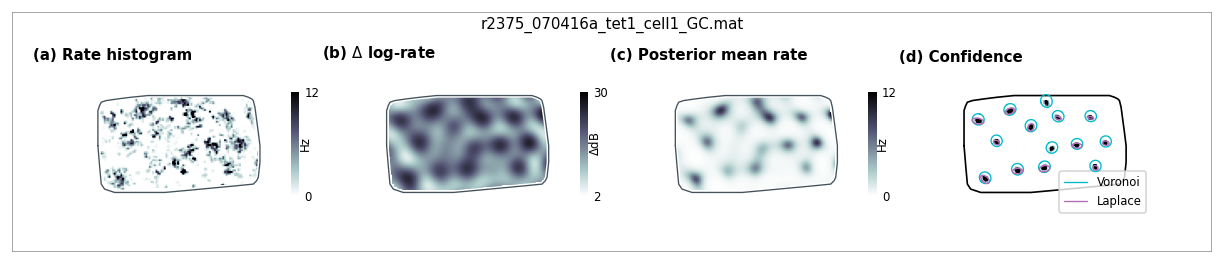

r2375_140416b_tet1_cell1_GC.mat


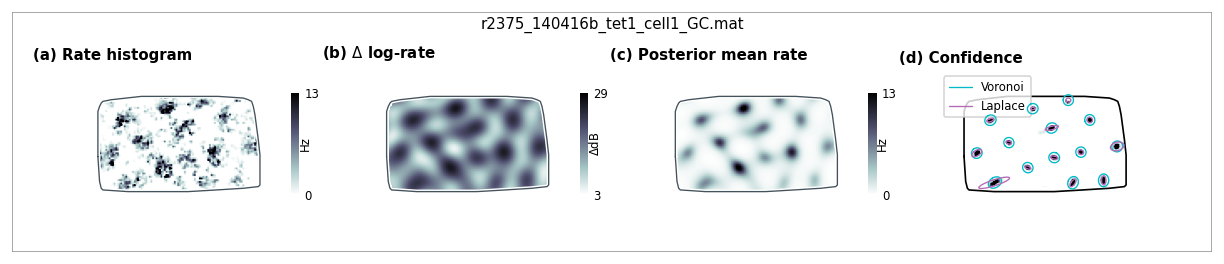

r2375_210416a_tet3_cell3_GC.mat


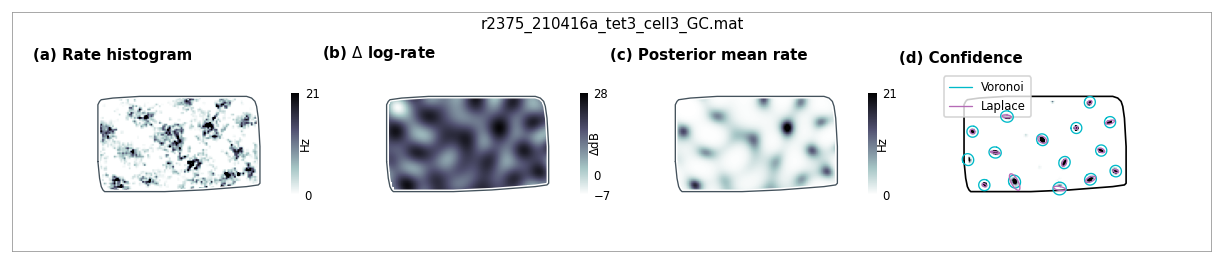

r2383_160516b_tet4_cell4_GC.mat


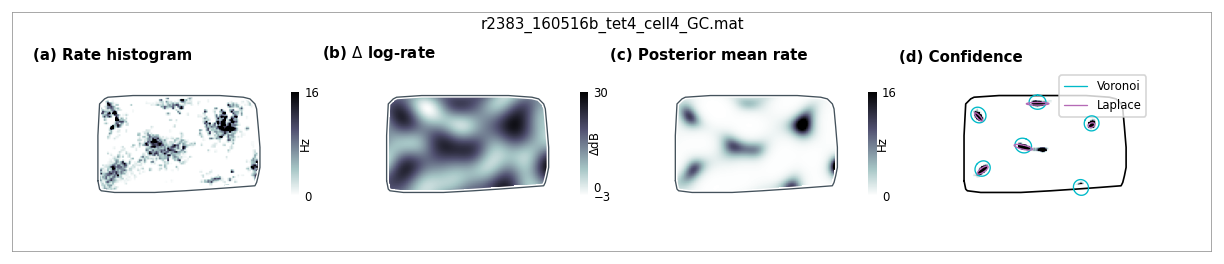

r2405_011216a_cell2955.mat


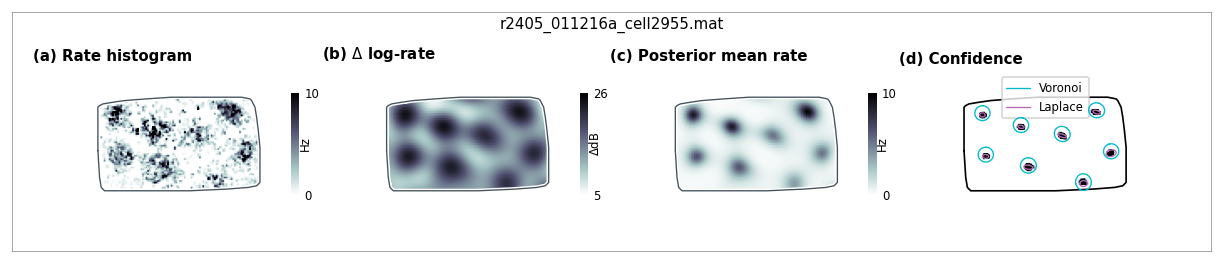

r2405_051216b_cell1816.mat


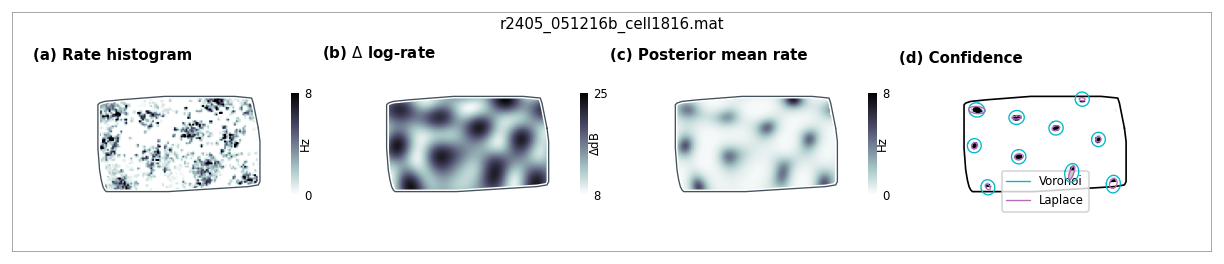

r2405_121216b_cell1880.mat


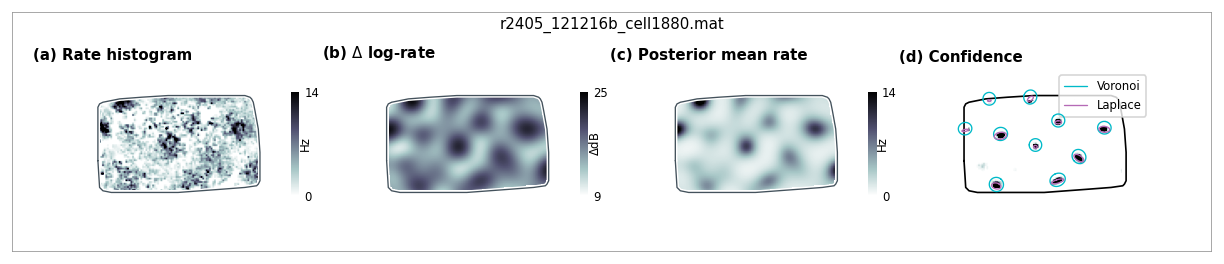

r2405_121216b_cell1912.mat


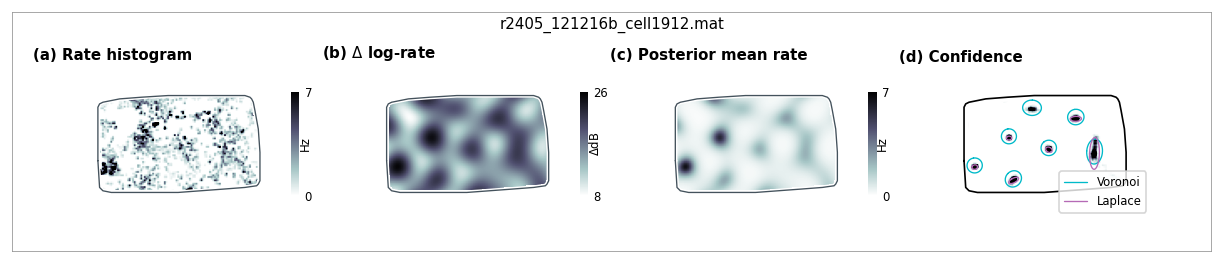

r2405_191216c_cell1640.mat


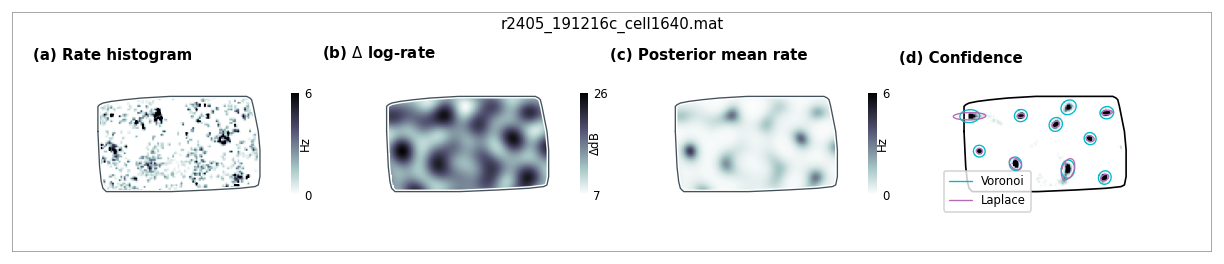

r2405_191216c_cell1662.mat


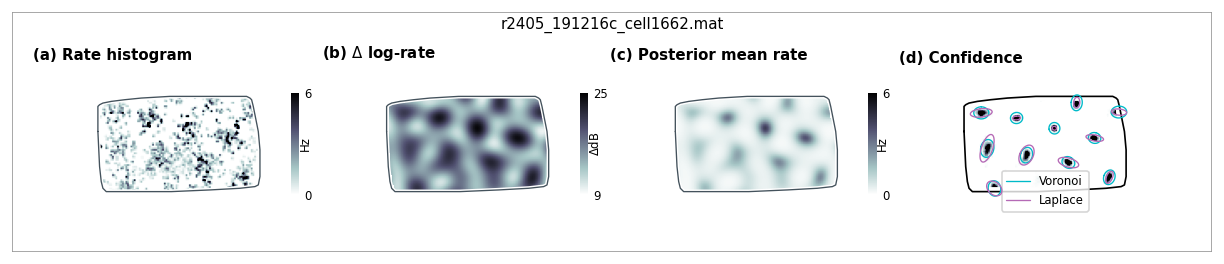

r2405_191216c_cell1962.mat


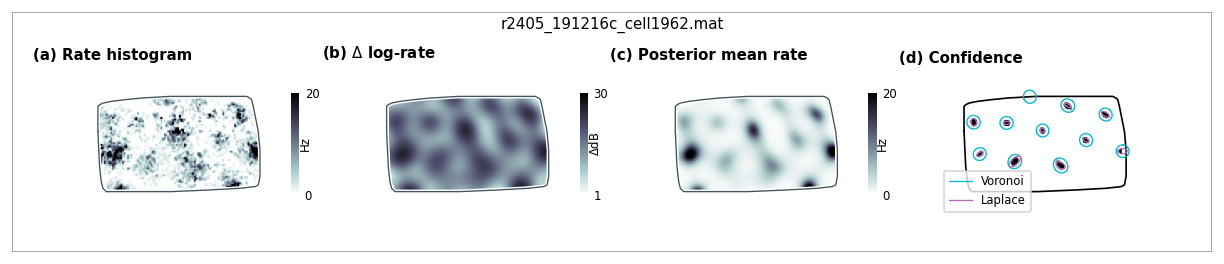

r2405_191216c_cell1990.mat


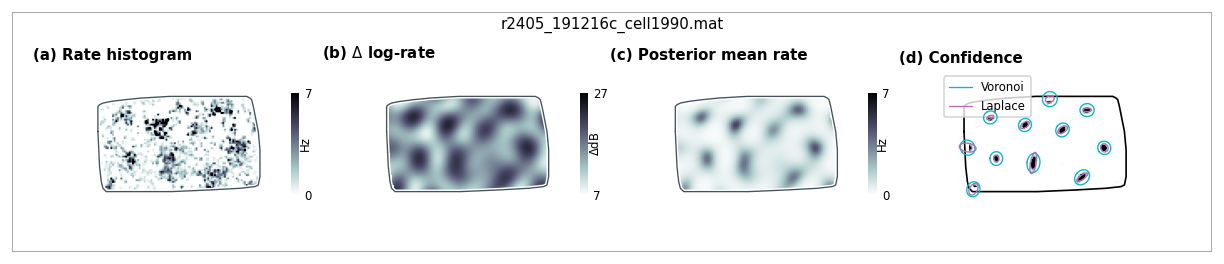

In [2]:
L        = 128
nsamples = 500 # Samples to draw
res      = 1    # Upsampling resolution relative to grid

for fn in datafiles:
    print(fn)
    data   = Dataset.from_file(datadir+fn).prepare(L)
    arena  = data.arena
    H,W    = data.shape
    
    # Fit model
    saveto = fn[:-4]+'.hyperparameters.p'
    P,V,θ  = pickle.load(open(fitdir+saveto,'rb'))
    kf     = kernelft(data.shape,P,V,style='grid',angle=θ)
    result,model = lgcp2d(kf,data.N,data.K,data.prior_mean)
    (z,v),nll,(r,zh,vh,zf) = result
        
    # Sample posterior
    radius = int(res*P/2)
    sample = model.sample(nsamples)
    ppeak  = peak_density(sample,res,P/2,-inf)/nsamples
    kde    = blur2d(ppeak,radius/7)
    mask2  = data.arena.make_mask(H*res,W*res)>0
    peaks  = interpolate_peaks(kde,radius,percentile(kde[mask2],95))
    peakm  = arena.unit_to_meters(peaks[::-1])
    keep   = arena.distance_to_boundary(peakm)>0.05
    
    def plotit():
        arena.imshow(ppeak,vmax=percentile(ppeak,99),cmap='bone_r')
        plot(*arena.perim_m.T,lw=1,color='k')
        noxyaxes()
    def plot_ellipses(M,S,units=None,**kw):
        ellipses = []
        for m,s in zip(M,S):
            #if not is_in_hull([m],data.arena.hull): continue
            m2 = [m] if units=='meters' else arena.unit_to_meters([m[::-1]])
            if not arena.contains(m2): continue
            z = covariance_crosshairs(s,.95,draw_cross=False) + m[:,None]
            ellipses += [*z.T]+[(NaN,NaN)]
        plotit()
        if units=='meters':
            plot(*float32(ellipses).T,**kw)#[::-1])
        else:
            ellipses = clip(ellipses,0,1).T
            plot(*arena.unit_to_meters(ellipses[::-1]),**kw)

    ### Covariances in Voronoi cells 
    rz      = [1,1j]@peakm
    zg      = arena.zgrid_meters(res)
    D       = abs(zg[:,:,None]-rz[None,None,:])
    nearest = float32(argmin(D,axis=2))
    nearest[nanmin(D,axis=2)>P/L*0.7]=NaN
    field_ids = unique(nearest)
    field_ids = int32(field_ids[isfinite(field_ids)])
    means1,sigmas1 = [],[]
    for i,pxy in enumerate(peaks.T):
        match         = nearest==i
        regional      = kde[match]
        total         = sum(regional)
        if total<= 0.0: continue
        pr    = regional/total
        mu    = sum(zg[match]*pr)
        delta = c2p(zg[match]-mu)
        sigmas1.append(einsum('zN,ZN,N->zZ',delta,delta,pr))
        means1.append(c2p(mu))

    ### Covariances from Laplace approximation 
    (z,v),nll,(r,uh,vh,mu) = result
    peaks = interpolate_peaks(z,P/2,-inf)[:2]
    pidx = tuple(int32(np.round(peaks*array(arena.shape)[:,None])))
    H    = -hessian_2D(z)[pidx]
    Q    = model._C(uh,vh)
    dx   = dxo(arena.shape)
    dy   = dyo(arena.shape)
    fx   = fft2(dx,norm='ortho')[model.kept]
    fy   = fft2(dy,norm='ortho')[model.kept]
    fQ   = h2f_2d_truncated(Q,arena.shape,model.kept)
    dxQ  = RI((fx.T*fQ.T).T)
    dyQ  = RI((fy.T*fQ.T).T)
    ispk = model.Gm.reshape(model.R,*arena.shape[::-1]).T[pidx]
    J    = array([ispk@dxQ,ispk@dyQ]).transpose(1,0,2)
    means2  = peaks.T
    sigmas2 = []
    for ii,(h,j) in enumerate(zip(H,J)):
        ΣxJD = chsolve(h,j)
        Σx0  = ΣxJD@ΣxJD.T
        sigmas2.append(Σx0)

    rmax = int(ceil(percentile(data.Y*data.position_sample_rate,99)))
    figure(0,(10,2.0),120)
    subplots_adjust(0.05,0,0.95,.9,0.35,0)
    subplot(141)
    im = arena.imshow(data.Y*data.position_sample_rate,cmap='bone_r',vmin=0,vmax=rmax,lw=2.5)
    plot(*arena.perim_m.T,lw=0.8,color=BLACK)
    good_colorbar(*im.get_clim(),cmap='bone_r',title='Hz',width=8,vscale=.7,fontsize=7)
    subfigurelabel('(a) Rate histogram',fontsize=9)
    subplot(142)
    ddb  = log10(exp(result.zv.z)*data.position_sample_rate)*10
    vmin = floor(np.min(ddb))
    vmax = ceil(np.max(ddb))
    im = arena.imshow(ddb,vmin=vmin,vmax=vmax,cmap='bone_r',lw=2.5)
    plot(*arena.perim_m.T,lw=0.8,color=BLACK)
    good_colorbar(*im.get_clim(),cmap='bone_r',title='$\\Delta$dB',width=8,vscale=.7,fontsize=7)
    subfigurelabel('(b) $\\Delta$ log-rate',fontsize=9)
    subplot(143)
    im=arena.imshow(result.info.r*data.position_sample_rate,cmap='bone_r',vmin=0,vmax=rmax,lw=2.5)
    plot(*arena.perim_m.T,lw=0.8,color=BLACK)
    good_colorbar(*im.get_clim(),cmap='bone_r',title='Hz',width=8,vscale=.7,fontsize=7)
    subfigurelabel('(c) Posterior mean rate',fontsize=9)
    subplot(144)
    arena.imshow(ppeak,100)
    plot_ellipses(means1,sigmas1,'meters',color=TEAL,label='Voronoi',lw=.8,zorder=10)
    plot_ellipses(means2,sigmas2,color=MAUVE,label='Laplace',lw=.8,zorder=10)
    legend()
    subfigurelabel('(d) Confidence',fontsize=9)
    figurebox()
    suptitle(fn)
    savefig('fig4v3_%s.pdf'%fn.split('/')[-1][:-4])
    savefig('fig4v3_%s.svg'%fn.split('/')[-1][:-4])
    show()